# Table of contents

[Supervised - basic models](./supervised_basic.ipynb)

[Supervised - RNN models](./supervised_rnn.ipynb)

[Unsupervised - Word2Vec](./unsupervised_w2v.ipynb)

[Unsupervised - Dimensionality Reduction](./unsupervised_dim.ipynb)

[Unsupervised - LDA](./unsupervised_LDA.ipynb)

[Performance Evaluation](./evaluation.ipynb)

In [41]:
# Suppress all warnings
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd

import re
import random
import time

from collections import Counter, defaultdict

from sklearn.dummy import DummyClassifier
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPClassifier
from nltk.cluster import KMeansClusterer
from sklearn.cluster import KMeans

from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix

from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve
from sklearn.metrics import plot_precision_recall_curve
from sklearn.metrics import plot_roc_curve

from tqdm import tqdm
import pickle

import gensim
from gensim.models.word2vec import Word2Vec
from collections import Counter
from nltk.tokenize import sent_tokenize, word_tokenize
from gensim.test.utils import datapath

from sklearn.decomposition import TruncatedSVD

from nltk.corpus import stopwords


from preprocess_helper import preprocess_helper
from evaluation_helper import evaluation_helper

In [39]:
RANDOM_SEED = 42

evaluator = evaluation_helper()

In [3]:
preprocessor = preprocess_helper('data/WikiLarge_Train.csv')
train_df=preprocessor.get_df().dropna()
train_df.head()

,original_text,label
0,There is manuscript evidence that Austen conti...,1
1,"In a remarkable comparative analysis , Mandaea...",1
2,"Before Persephone was released to Hermes , who...",1
3,Cogeneration plants are commonly found in dist...,1
4,"Geneva -LRB- , ; , ; , ; ; -RRB- is the second...",1


In [4]:
train_df.shape

(416768, 2)

In [5]:
X=train_df['original_text']
y=train_df['label']
    
X_train, X_test, y_train, y_test = preprocessor.train_test_split(X, y)

<class 'pandas.core.series.Series'>


In [6]:
X_train.shape

(333414,)

In [7]:
y_train.shape

(333414,)

In [8]:
%%time
min_df=50
ngram_range=(1,3)
stop_word=None
max_features= 5000

count_vectorizer = CountVectorizer(stop_words=stop_word, min_df=min_df, #max_features= max_features,
                                   lowercase = False, ngram_range=ngram_range).fit(X)

Wall time: 24.4 s


In [9]:
X_train_count=count_vectorizer.transform(X_train)
X_test_count=count_vectorizer.transform(X_test)
X_train_count.shape

(333414, 30006)

In [36]:
number_of_rows = X_train_count.shape[0]
random_indices = np.random.choice(number_of_rows, size=round(number_of_rows/10), replace=False)
X_train_count_sample = X_train_count[random_indices, :]
y_train_sample = y_train.iloc[random_indices]

print(X_train_count_sample.shape)
print(y_train_sample.shape)

(33341, 30006)
(33341,)


In [37]:
X_train_count_sample.shape

(33341, 30006)

In [38]:
X_train_count_sample_dense=X_train_count_sample.todense()
X_train_count_sample_dense.shape

(33341, 30006)

In [45]:
%%time
from sklearn.decomposition import PCA



n_components = [50, 100, 200, 400, 800]
for n_component in n_components:
    start_time = time.time()
    pca = PCA(n_components = n_component).fit(X_train_count_sample_dense)
    
    X_pca = pca.transform(X_train_count_sample_dense)
    
    kmeans_model = KMeans(n_clusters=2, init='k-means++', max_iter=100, n_init=10, random_state=RANDOM_SEED).fit(X_pca)
    labels = kmeans_model.labels_
    print('KMeans - PCA - component ' + str(n_component))
    evaluator.evaluate('KMeans_PCA_Sampled_' + str(n_component), y_train_sample, labels, time.time() - start_time)
    print()

KMeans - PCA - component 50
Completed in 593.73s
confusion matrix: 
 [[12905  3752]
 [11030  5654]] 

f1=  0.4334227673438099 ; accuracy=  0.5566419723463604 ; precision=  0.6011056772273017 ; recall=  0.3388875569407816
roc_auc=  0.5568184557832323

KMeans - PCA - component 100
Completed in 219.75s
confusion matrix: 
 [[ 3746 12911]
 [ 5655 11029]] 

f1=  0.5429795194958645 ; accuracy=  0.4431480759425332 ; precision=  0.4606934001670844 ; recall=  0.6610525053943899
roc_auc=  0.4429714709237663

KMeans - PCA - component 200
Completed in 202.56s
confusion matrix: 
 [[12903  3754]
 [11027  5657]] 

f1=  0.43356964935811454 ; accuracy=  0.556671965447947 ; precision=  0.6011050897885453 ; recall=  0.3390673699352673
roc_auc=  0.5568483274602795

KMeans - PCA - component 400
Completed in 401.58s
confusion matrix: 
 [[12908  3749]
 [11030  5654]] 

f1=  0.4334726108789819 ; accuracy=  0.5567319516511202 ; precision=  0.6012974582580027 ; recall=  0.3388875569407816
roc_auc=  0.55690850801

In [44]:
%%time
from sklearn.decomposition import TruncatedSVD




n_topics = [50, 100, 200, 400, 800]
for n_topic in n_topics:
    start_time = time.time()
    lsi = TruncatedSVD(n_components=n_topic, random_state=RANDOM_SEED)
    
    reduced_term_matrix = lsi.fit_transform(X_train_count_sample)
    
    kmeans_model = KMeans(n_clusters=2, init='k-means++', max_iter=100, n_init=10, random_state=RANDOM_SEED).fit(reduced_term_matrix)
    labels = kmeans_model.labels_
    print('KMeans - TruncatedSVD - component ' + str(n_topic))
    evaluator.evaluate('KMeans_TruncatedSVD_Sampled_' + str(n_topic), y_train_sample, labels, time.time() - start_time)
    print()

KMeans - TruncatedSVD - component 50
Completed in 3.53s
confusion matrix: 
 [[ 3748 12909]
 [ 5646 11038]] 

f1=  0.5433289852575619 ; accuracy=  0.4434780000599862 ; precision=  0.4609345638284545 ; recall=  0.6615919443778471
roc_auc=  0.4433012252356906

KMeans - TruncatedSVD - component 100
Completed in 4.73s
confusion matrix: 
 [[12906  3751]
 [11030  5654]] 

f1=  0.4334393805818545 ; accuracy=  0.556671965447947 ; precision=  0.6011695906432749 ; recall=  0.3388875569407816
roc_auc=  0.5568484731933301

KMeans - TruncatedSVD - component 200
Completed in 7.99s
confusion matrix: 
 [[12905  3752]
 [11029  5655]] 

f1=  0.4334828101644246 ; accuracy=  0.556671965447947 ; precision=  0.6011480812161156 ; recall=  0.3389474946056102
roc_auc=  0.5568484246156465

KMeans - TruncatedSVD - component 400
Completed in 14.70s
confusion matrix: 
 [[ 3740 12917]
 [ 5651 11033]] 

f1=  0.5430427720628045 ; accuracy=  0.4430880897393599 ; precision=  0.4606680584551148 ; recall=  0.6612922560537

In [47]:
n_topics = [50, 100, 200, 400, 800]
for n_topic in n_topics:
    start_time = time.time()
    lsi = TruncatedSVD(n_components=n_topic, random_state=RANDOM_SEED)
    
    reduced_term_matrix = lsi.fit_transform(X_train_count)
    
    kmeans_model = KMeans(n_clusters=2, init='k-means++', max_iter=100, n_init=10, random_state=RANDOM_SEED).fit(reduced_term_matrix)
    labels = kmeans_model.labels_
    print('KMeans - TruncatedSVD - component ' + str(n_topic))
    evaluator.evaluate('KMeans_TruncatedSVD_' + str(n_topic), y_train, labels, time.time() - start_time)
    print()

KMeans - TruncatedSVD - component 50
Completed in 16.21s
confusion matrix: 
 [[ 38232 128603]
 [ 57096 109483]] 

f1=  0.541104370281591 ; accuracy=  0.4430377848560648 ; precision=  0.45984644204195124 ; recall=  0.6572437101915608
roc_auc=  0.4432021290191178

KMeans - TruncatedSVD - component 100
Completed in 32.42s
confusion matrix: 
 [[128566  38269]
 [109435  57144]] 

f1=  0.4362270603682555 ; accuracy=  0.5569952071598673 ; precision=  0.5989120979321476 ; recall=  0.34304444137616386
roc_auc=  0.5568310587616278

KMeans - TruncatedSVD - component 200
Completed in 60.87s
confusion matrix: 
 [[128603  38232]
 [109490  57089]] 

f1=  0.43596029018709426 ; accuracy=  0.5569412202247056 ; precision=  0.5989131461063144 ; recall=  0.3427142677048127
roc_auc=  0.5567768599290689

KMeans - TruncatedSVD - component 400
Completed in 114.49s
confusion matrix: 
 [[ 38221 128614]
 [ 57094 109485]] 

f1=  0.5410968720810125 ; accuracy=  0.443010791388484 ; precision=  0.4598297346901919 ; r

In [13]:
%%time
from sklearn.decomposition import PCA

pca = PCA(n_components = 2).fit(X_train_count_sample_dense)

Wall time: 47 s


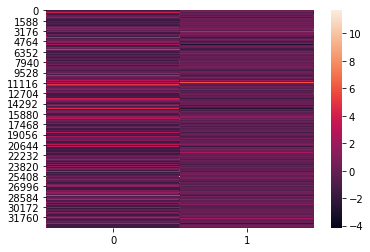

In [16]:
import seaborn as sn

sn.heatmap(X_pca)

In [17]:
y_train_sample=y_train.iloc[random_indices.tolist()]

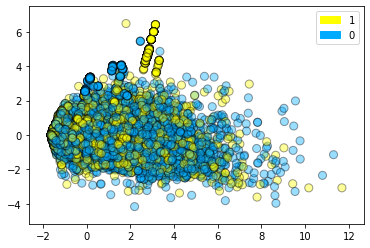

In [18]:
from adspy_shared_utilities import plot_labelled_scatter

plot_labelled_scatter(X_pca, y_train_sample, ['1', '0'])

In [19]:
%%time

from sklearn.preprocessing import StandardScaler

X_normalized = StandardScaler().fit(X_train_count_sample_dense).transform(X_train_count_sample_dense)  
pca_n = PCA(n_components = 2).fit(X_normalized)
X_pca_n = pca.transform(X_normalized)

Wall time: 2min 41s


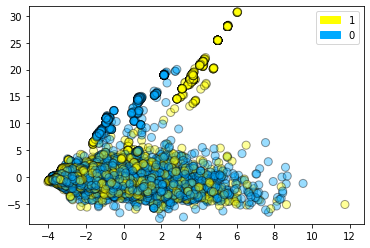

In [20]:
plot_labelled_scatter(X_pca_n, y_train_sample, ['1', '0'])

In [21]:
feature_names=list(count_vectorizer.get_feature_names())[:10]
feature_names

['00',
 '000',
 '000 000',
 '000 LRB',
 '000 RRB',
 '000 and',
 '000 articles',
 '000 copies',
 '000 in',
 '000 inhabitants']

In [22]:
pca.components_[0].shape

(30006,)

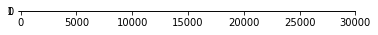

In [23]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.imshow(pca_n.components_[0:2], interpolation = 'none', cmap = 'plasma')

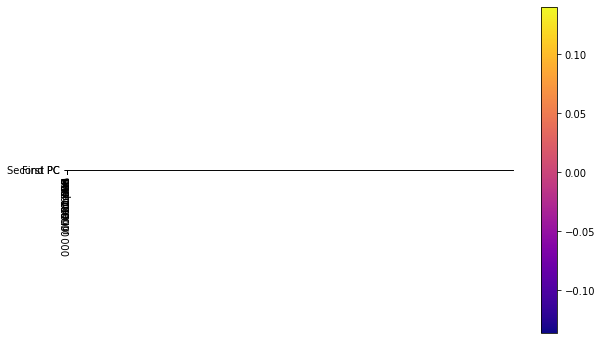

In [24]:
%matplotlib inline
import matplotlib.pyplot as plt

def plot_pca(pca, top_k = 2):
    fig, ax = plt.subplots(figsize=(10,6))
    plt.imshow(pca.components_[0:top_k], interpolation = 'none', cmap = 'plasma')
    feature_names=list(count_vectorizer.get_feature_names())[:10]
    plt.xticks(np.arange(-0., len(feature_names), 1) , feature_names, rotation = 90, fontsize=10)
    plt.yticks(np.arange(0., 2, 1), ['First PC', 'Second PC'], fontsize = 10)
    plt.colorbar()
    
plot_pca(pca_n)

In [25]:
%%time
n_topics = 500
lsi = TruncatedSVD(n_components=n_topics, random_state=RANDOM_SEED)
reduced_term_matrix = lsi.fit_transform(X_train_count)
reduced_term_matrix.shape

Wall time: 2min 24s


(333414, 500)

In [26]:
%%time
from sklearn.cluster import KMeans
from sklearn import metrics


kmeans_model = KMeans(n_clusters=2, init='k-means++', max_iter=100, n_init=1, random_state=RANDOM_SEED).fit(X_train_count)
labels = kmeans_model.labels_
f1_score(y_train, labels, average='macro')

Wall time: 3min 8s


0.5356590435370859

In [49]:
n_topics = [50, 100, 200, 400, 800]
for n_topic in n_topics:
    start_time = time.time()
    lsi = TruncatedSVD(n_components=n_topic, random_state=RANDOM_SEED)
    
     
    reduced_term_matrix_train = lsi.fit_transform(X_train_count)
    reduced_term_matrix_test = lsi.fit_transform(X_test_count)
    clf = LogisticRegression(solver= 'lbfgs', max_iter=10000, 
                                 random_state=RANDOM_SEED).fit(reduced_term_matrix_train, y_train)
    y_pred=clf.predict(reduced_term_matrix_test)
    print('LogisticRegression - TruncatedSVD - component ' + str(n_topic))
    evaluator.evaluate('LogisticRegression_TruncatedSVD_' + str(n_topic), y_test, y_pred, time.time() - start_time)
    print()

LogisticRegression - TruncatedSVD - component 50
Completed in 19.84s
confusion matrix: 
 [[28959 12590]
 [22480 19325]] 

f1=  0.5242810634834508 ; accuracy=  0.5792643424430741 ; precision=  0.6055146482845057 ; recall=  0.46226527927281424
roc_auc=  0.5796247814448743

LogisticRegression - TruncatedSVD - component 100
Completed in 43.60s
confusion matrix: 
 [[28540 13009]
 [22274 19531]] 

f1=  0.5254152935637905 ; accuracy=  0.5767089761739088 ; precision=  0.6002151198524892 ; recall=  0.46719291950723596
roc_auc=  0.5770463622783478

LogisticRegression - TruncatedSVD - component 200
Completed in 79.82s
confusion matrix: 
 [[27946 13603]
 [21935 19870]] 

f1=  0.5279098807088393 ; accuracy=  0.5736497348657533 ; precision=  0.5936127625250202 ; recall=  0.4753019973687358
roc_auc=  0.5739527147304821

LogisticRegression - TruncatedSVD - component 400
Completed in 171.28s
confusion matrix: 
 [[27621 13928]
 [21981 19824]] 

f1=  0.5247429093267334 ; accuracy=  0.5691988386880054 ; p

In [41]:
%%time


for i in range (2, 10):
    kmeans_model = KMeans(n_clusters=i, init='k-means++', max_iter=100, n_init=5, random_state=RANDOM_SEED).fit(reduced_term_matrix)
    labels = kmeans_model.labels_
    calinski_harabasz_score=metrics.calinski_harabasz_score(reduced_term_matrix, labels)
    davies_bouldin_score=metrics.davies_bouldin_score(reduced_term_matrix, labels)
    print (i, calinski_harabasz_score, davies_bouldin_score)

2 38491.70832709503 2.71018619324314
3 27334.42722058073 2.4489445215724994
4 22280.201801048686 3.089301459178785
5 19455.361126442 2.97095635685298
6 16940.630456192655 3.2009061848324425
7 15289.300805553185 3.0131705136028057
8 13987.90599240132 3.1210395336082217
9 12936.190991054533 3.1159376009124595
Wall time: 18min 24s


In [66]:
%%time
kmeans_model = KMeans(n_clusters=20, init='k-means++', max_iter=100, n_init=10, random_state=RANDOM_SEED).fit(X_train_count)
labels = kmeans_model.labels_

labels_df=pd.DataFrame(labels, index=X_train.index)
labels_df['true label']=y_train
labels_df.columns=['cluster label', 'true label']


for i in range(20):
    labels_df_cluster=labels_df[labels_df['cluster label']==i]
    print('number of clusters=', i, labels_df_cluster['true label'].value_counts())

number of clusters= 0 0    2904
1    1943
Name: true label, dtype: int64
number of clusters= 1 1    4104
0    2225
Name: true label, dtype: int64
number of clusters= 2 1    13653
0    13630
Name: true label, dtype: int64
number of clusters= 3 1    8831
0    6402
Name: true label, dtype: int64
number of clusters= 4 1    4240
0     184
Name: true label, dtype: int64
number of clusters= 5 0    12819
1    11428
Name: true label, dtype: int64
number of clusters= 6 1    8378
0    4497
Name: true label, dtype: int64
number of clusters= 7 1    7417
0    4445
Name: true label, dtype: int64
number of clusters= 8 1    14092
0    13302
Name: true label, dtype: int64
number of clusters= 9 1    4739
0    2266
Name: true label, dtype: int64
number of clusters= 10 1    10265
0     6187
Name: true label, dtype: int64
number of clusters= 11 1    1048
0     993
Name: true label, dtype: int64
number of clusters= 12 0    668
1    561
Name: true label, dtype: int64
number of clusters= 13 0    16854
1    151

In [67]:
%%time
kmeans_model = KMeans(n_clusters=20, init='k-means++', max_iter=100, n_init=10, random_state=RANDOM_SEED).fit(reduced_term_matrix)
labels = kmeans_model.labels_

labels_df=pd.DataFrame(labels, index=X_train.index)
labels_df['true label']=y_train
labels_df.columns=['cluster label', 'true label']


for i in range(20):
    labels_df_cluster=labels_df[labels_df['cluster label']==i]
    print('number of clusters=', i, labels_df_cluster['true label'].value_counts())
    

number of clusters= 0 1    8050
0    6296
Name: true label, dtype: int64
number of clusters= 1 0    12600
1    12156
Name: true label, dtype: int64
number of clusters= 2 1    1048
0     993
Name: true label, dtype: int64
number of clusters= 3 1    6656
0    3218
Name: true label, dtype: int64
number of clusters= 4 0    46888
1    24038
Name: true label, dtype: int64
number of clusters= 5 1    5310
0    3099
Name: true label, dtype: int64
number of clusters= 6 1    10303
0     8994
Name: true label, dtype: int64
number of clusters= 7 1    7439
0    4031
Name: true label, dtype: int64
number of clusters= 8 1    8988
0    5836
Name: true label, dtype: int64
number of clusters= 9 1    4780
0    4652
Name: true label, dtype: int64
number of clusters= 10 1    4792
0     184
Name: true label, dtype: int64
number of clusters= 11 1    17520
0    16746
Name: true label, dtype: int64
number of clusters= 12 1    6142
0    4297
Name: true label, dtype: int64
number of clusters= 13 1    1690
0     8

In [68]:
cluster10=labels_df[labels_df['cluster label']==10]
cluster10.head()

,cluster label,true label
100538,10,1
39697,10,1
175707,10,1
138806,10,1
156879,10,1


In [54]:
%%time
kmeans_model = KMeans(n_clusters=3, init='k-means++', max_iter=100, n_init=10, random_state=RANDOM_SEED).fit(reduced_term_matrix)
labels = kmeans_model.labels_

labels_df=pd.DataFrame(labels, index=X_train.index)
labels_df.head()

Wall time: 2min 8s


,0
304501,1
162313,2
336845,1
150625,2
40240,1


In [55]:
labels_df['true label']=y_train
labels_df.columns=['cluster label', 'true label']
labels_df.head()

,cluster label,true label
304501,1,0
162313,2,1
336845,1,0
150625,2,1
40240,1,1


In [61]:
labels_df_cluster0=labels_df[labels_df['cluster label']==0]
labels_df_cluster0['true label'].value_counts()

1    6572
0    4781
Name: true label, dtype: int64

In [62]:
labels_df_cluster1=labels_df[labels_df['cluster label']==1]
labels_df_cluster1['true label'].value_counts()

0    128226
1    105891
Name: true label, dtype: int64

In [63]:
labels_df_cluster2=labels_df[labels_df['cluster label']==2]
labels_df_cluster2['true label'].value_counts()

1    54116
0    33828
Name: true label, dtype: int64

In [28]:
#%%time

#from sklearn.cluster import AgglomerativeClustering


#cls_a = AgglomerativeClustering(n_clusters = 2)
#cls_assignment = cls_a.fit_predict(reduced_term_matrix)
#f1_score(y_train, cls_assignment, average='macro')

In [29]:
#feature_array = np.array(count_vectorizer.get_feature_names())
#count_sorting = np.argsort(X_count_sample.toarray())[::-1]
#n=20
#top_n = feature_array[count_sorting][:n]

In [30]:
list(count_vectorizer.get_feature_names())[:10]

['00',
 '000',
 '000 000',
 '000 LRB',
 '000 RRB',
 '000 and',
 '000 articles',
 '000 copies',
 '000 in',
 '000 inhabitants']

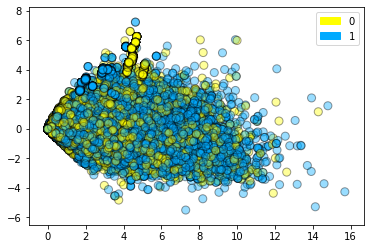

In [31]:
%matplotlib inline
import matplotlib.pyplot as plt
from adspy_shared_utilities import plot_labelled_scatter

plot_labelled_scatter(reduced_term_matrix, y_train, ['0', '1'])

In [34]:
reduced_term_matrix.shape

(333414, 500)

In [43]:
random_indices2 = np.random.choice(number_of_rows, size=round(number_of_rows/100), replace=False)
reduced_term_matrix_sample=reduced_term_matrix[random_indices2, :]
reduced_term_matrix_sample.shape
y_train_sample2=y_train.iloc[random_indices2.tolist()]

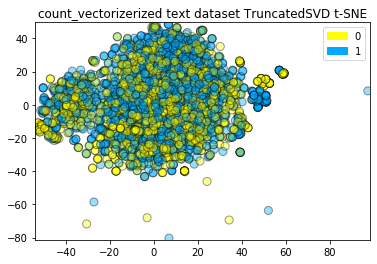

In [46]:
from sklearn.manifold import TSNE

tsne = TSNE(random_state = RANDOM_SEED)

X_tsne = tsne.fit_transform(reduced_term_matrix_sample)


plot_labelled_scatter(X_tsne, y_train_sample2, 
    ['0', '1'], title = "count_vectorizerized text dataset TruncatedSVD t-SNE")

In [47]:
X_train_count_sample2 = X_train_count[random_indices2, :]

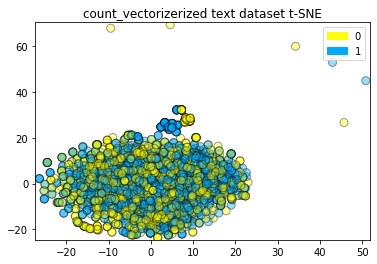

In [48]:
tsne = TSNE(random_state = RANDOM_SEED)

X_tsne = tsne.fit_transform(X_train_count_sample2)


plot_labelled_scatter(X_tsne, y_train_sample2, 
    ['0', '1'], title = "count_vectorizerized text dataset t-SNE")